In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset, get_dataset_split_names, DatasetDict
from tqdm import tqdm

sns.set_color_codes("colorblind")
sns.set_theme(style="darkgrid")
sns.set_context("talk")
tqdm.pandas()

/home/mchorse/miniconda3/envs/memorization/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Datasets

In [2]:
split_sample_size = None
label_title_padding = 10
study_pile = False
RECITATION_THRESHOLD = 10

In [3]:
memories_path = "usvsnsp/generation-semantic-filters"
intermediate_path = "usvsnsp/generation-semantic-intermediate-filters"
memories_dataset = DatasetDict()
splits = [split for split in get_dataset_split_names(memories_path) if "deduped" in split] + get_dataset_split_names(intermediate_path)
# drop splits with "pile" in the name
splits = [split for split in splits if "pile" not in split and "deduped" in split]
print(splits)

['memories_deduped_410m', 'memories_deduped_1.4b', 'memories_deduped_6.9b', 'memories_deduped_1b', 'memories_deduped_12b', 'memories_deduped_70m', 'memories_deduped_2.8b', 'memories_deduped_160m', 'memories_deduped_12b.43000', 'memories_deduped_12b.103000', 'memories_deduped_12b.83000', 'memories_deduped_12b.63000', 'memories_deduped_12b.123000', 'memories_deduped_12b.23000']


In [4]:
print("Loading datasets...")
print(f"Split sample size: {split_sample_size}")

for split in tqdm(splits):
    model = split.split("_")[-1]
    checkpoint = int(split.split(".")[-1]) if split.split(".")[-1][1].isnumeric() else "Final"
    formatted_split_name = split.replace("memories_", "").replace("deduped_", "deduped.")
    dataset_path = memories_path if checkpoint == "Final" else intermediate_path
    memories_dataset[formatted_split_name] = load_dataset(dataset_path, split=f"{split}[:{split_sample_size}]" if split_sample_size else split)

memories_dataset

Loading datasets...
Split sample size: None


100%|██████████| 14/14 [02:21<00:00, 10.14s/it]


DatasetDict({
    deduped.410m: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'index', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
        num_rows: 811040
    })
    deduped.1.4b: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'index', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
    

In [5]:
split_to_param_count = {
    "70m": 70000000,
    "160m": 160000000,
    "410m": 410000000,
    "1b": 1000000000,
    "1.4b": 1400000000,
    "2.8b": 2800000000,
    "6.9b": 6900000000,
    "12b": 12000000000,
}

In [6]:
columns_to_drop = ["frequencies", "tokens"]
combined_dataframe = None
for split in tqdm(memories_dataset, desc="Loading Memories"):
    current_frame = memories_dataset[split].to_pandas()
    current_frame.drop(columns=columns_to_drop, inplace=True)
    checkpoint = int(split.split(".")[-1]) if split.split(".")[-1][1].isnumeric() and len(split.split(".")) != 2 else "Final"
    current_frame["Checkpoint"] = checkpoint
    model = split.split("deduped")[-1][1:] if checkpoint == "Final" else split.split(".")[-2]
    print(f"Model: {model} from {split}")
    current_frame["Model"] = model
    current_frame["Param Count"] = split_to_param_count[current_frame["Model"].iloc[0]]
    current_frame["Deduped"] = "deduped" in split
    current_frame["Memorized"] = True
    if combined_dataframe is None:
        combined_dataframe = current_frame
    else:
        combined_dataframe = pd.concat([combined_dataframe, current_frame])

combined_dataframe = combined_dataframe.sort_values("Param Count")
display(combined_dataframe.shape)
display(combined_dataframe.columns)
combined_dataframe.head()

Loading Memories:   7%|▋         | 1/14 [00:01<00:18,  1.44s/it]

Model: 410m from deduped.410m
Model: 1.4b from deduped.1.4b


Loading Memories:  14%|█▍        | 2/14 [00:03<00:22,  1.84s/it]

Model: 6.9b from deduped.6.9b


Loading Memories:  21%|██▏       | 3/14 [00:07<00:29,  2.67s/it]

Model: 1b from deduped.1b


Loading Memories:  29%|██▊       | 4/14 [00:09<00:26,  2.67s/it]

Model: 12b from deduped.12b


Loading Memories:  36%|███▌      | 5/14 [00:14<00:29,  3.26s/it]

Model: 70m from deduped.70m


Loading Memories:  43%|████▎     | 6/14 [00:15<00:21,  2.71s/it]

Model: 2.8b from deduped.2.8b


Loading Memories:  50%|█████     | 7/14 [00:19<00:20,  2.92s/it]

Model: 160m from deduped.160m


Loading Memories:  57%|█████▋    | 8/14 [00:21<00:15,  2.63s/it]

Model: 12b from deduped.12b.43000


Loading Memories:  64%|██████▍   | 9/14 [00:23<00:12,  2.42s/it]

Model: 12b from deduped.12b.103000


Loading Memories:  71%|███████▏  | 10/14 [00:26<00:10,  2.73s/it]

Model: 12b from deduped.12b.83000


Loading Memories:  79%|███████▊  | 11/14 [00:29<00:08,  2.83s/it]

Model: 12b from deduped.12b.63000


Loading Memories:  86%|████████▌ | 12/14 [00:32<00:05,  2.74s/it]

Model: 12b from deduped.12b.123000


Loading Memories:  93%|█████████▎| 13/14 [00:37<00:03,  3.39s/it]

Model: 12b from deduped.12b.23000


Loading Memories: 100%|██████████| 14/14 [00:39<00:00,  2.79s/it]


(13510441, 28)

Index(['sequence_id', 'text', 'is_incrementing', 'is_repeating',
       'sequence_duplicates', 'max_frequency', 'avg_frequency',
       'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency',
       'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates',
       '0_9_templates', 'huffman_coding_length', 'memorization_score', 'index',
       'loss', 'prompt_perplexity', 'generation_perplexity',
       'sequence_perplexity', 'Checkpoint', 'Model', 'Param Count', 'Deduped',
       'Memorized'],
      dtype='object')

,sequence_id,text,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,p25_frequency,...,index,loss,prompt_perplexity,generation_perplexity,sequence_perplexity,Checkpoint,Model,Param Count,Deduped,Memorized
311692,76369286,"09-01636],[@B243-cells-09-01636],[@B244-cells-...",True,False,3,2965935634,9.619414e+08,1466086,26718143.5,3396213,...,76369286.0,0.901367,1.762004,1.028962,1.813036,Final,70m,70000000,True,True
274304,101528653,"0 (the ""License"");\n// you may not use this fi...",False,False,126590,11740996961,2.183443e+09,2535454,397855078.0,24463239,...,101528653.0,0.828125,2.405067,1.001652,2.409041,Final,70m,70000000,True,True
274303,101488489,permissions and limitations under the License...,False,False,12551,11740996961,2.955296e+09,605886,223388936.0,16400100,...,101488489.0,0.895020,2.173179,1.022547,2.222178,Final,70m,70000000,True,True
274302,101355445,"nbsp;</span></caption>\n<tr>\n<th class=""colFi...",False,False,39601,11740996961,1.373194e+09,1033836,87048161.0,10406762,...,101355445.0,0.788574,3.974078,1.012878,4.025258,Final,70m,70000000,True,True
274301,101319862,"/or sell\n * copies of the Software, and to pe...",False,False,40819,11740996961,3.075328e+09,1317065,573756779.0,12931579,...,101319862.0,0.823242,1.956711,1.012603,1.981370,Final,70m,70000000,True,True


## Plot Graphs

## Figure: Perplexity and Duplication

(1107314, 29)

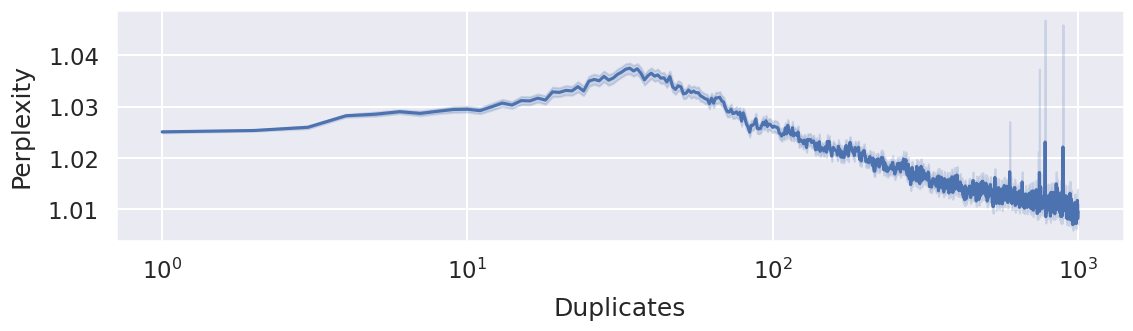

In [32]:
# line plot where sequence_duplicates is the x axis and the y axis is the generation_perplexity
deduped_12b = combined_dataframe[(combined_dataframe["Model"] == "12b") & (combined_dataframe["Checkpoint"] == "Final") & (combined_dataframe["Deduped"] == True)]

deduped_12b = deduped_12b[deduped_12b["sequence_duplicates"] <= 1000]

display(deduped_12b.shape)

# bucket the sequence_duplicates by 5
# deduped_12b["sequence_duplicates"] = deduped_12b["sequence_duplicates"].apply(lambda x: x - (x % 5))

sns.lineplot(data=deduped_12b, x="sequence_duplicates", y="generation_perplexity")

# y label is "Perplexity" and x label is "Duplicates"
plt.xlabel("Duplicates", labelpad=label_title_padding)
plt.ylabel("Perplexity", labelpad=label_title_padding)

# set figure dimensions
plt.gcf().set_size_inches(13, 3)

# log x axis
plt.xscale("log")

# log y axis
# plt.yscale("log")

In [33]:
# get mean and std dev for each bucket
duplication_ppl_stats = deduped_12b.groupby("sequence_duplicates").agg({"generation_perplexity": ["mean", "std"]})
display(duplication_ppl_stats)
duplication_ppl_stats.to_csv("duplication_ppl_stats.csv")

generation_perplexity          
                                     mean       std
sequence_duplicates                                
1                                1.025104  0.024197
2                                1.025370  0.024384
3                                1.025992  0.024715
4                                1.028239  0.024819
5                                1.028543  0.025477
...                                   ...       ...
996                              1.009864  0.011003
997                              1.008208  0.008315
998                              1.008946  0.009912
999                              1.009452  0.010223
1000                             1.009534  0.010113

[1000 rows x 2 columns]

### Assign Examples to Taxonomy

In [15]:
def get_category(row):
    if row["Memorized"] == False:
        return "Not Memorized"
    if row["sequence_duplicates"] >= RECITATION_THRESHOLD:
        return "Recitation"
    if row["is_incrementing"] or row["is_repeating"]:
        return "Reconstruction"

    return "Recollection"

combined_dataframe["category"] = combined_dataframe.progress_apply(lambda row: get_category(row), axis=1)
combined_dataframe.value_counts(["Model", "Checkpoint", "category"])

# 12 deduped
# memories_frame = combined_dataframe[(combined_dataframe["Memorized"] == True) & (combined_dataframe["Deduped"] == True) & (combined_dataframe["Model"] == "12b")]
# memories_frame["category"] = memories_frame.progress_apply(lambda row: get_category(row), axis=1)
# memories_frame.value_counts("category")

100%|██████████| 13510441/13510441 [02:44<00:00, 82120.19it/s] 


Model  Checkpoint  category      
12b    Final       Recitation        1521554
6.9b   Final       Recitation        1379503
12b    123000      Recitation        1271509
2.8b   Final       Recitation        1114324
12b    103000      Recitation         972908
1.4b   Final       Recitation         868737
1b     Final       Recitation         860603
12b    83000       Recitation         692617
410m   Final       Recitation         677656
160m   Final       Recitation         488998
12b    63000       Recitation         477775
70m    Final       Recitation         356982
12b    Final       Recollection       321445
       43000       Recitation         294235
6.9b   Final       Recollection       273262
12b    123000      Recollection       268342
2.8b   Final       Recollection       214053
12b    103000      Recollection       202754
1.4b   Final       Recollection       154990
1b     Final       Recollection       147248
12b    83000       Recollection       143741
       23000       Re

### Figure: Prevalence and Memories by Taxonomy Across Time and Scale

In [16]:
# Create plot for data across 
final_checkpoint_counts_frame = combined_dataframe[combined_dataframe["Checkpoint"] == "Final"].value_counts(["Param Count", "category"]).unstack().reindex(split_to_param_count.values())
final_checkpoint_counts_frame.to_csv(f"final_checkpoint_counts_recitation={RECITATION_THRESHOLD}.csv")
display(final_checkpoint_counts_frame)

intermediate_frame = combined_dataframe[(combined_dataframe["Checkpoint"] != "Final") & (combined_dataframe["Model"] == "12b")]
sorted_checkpoints = sorted(intermediate_frame["Checkpoint"].unique(), key=lambda x: int(x))

intermediate_checkpoint_counts_frame = intermediate_frame.value_counts(["Checkpoint", "category"]).unstack().reindex(sorted_checkpoints)
intermediate_checkpoint_counts_frame.to_csv(f"intermediate_checkpoint_counts_recitation={RECITATION_THRESHOLD}.csv")
display(intermediate_checkpoint_counts_frame)

category,Recitation,Recollection,Reconstruction
Param Count,,,
70000000,356982,38351,16115
160000000,488998,70805,21397
410000000,677656,109520,23864
1000000000,860603,147248,25021
1400000000,868737,154990,24377
2800000000,1114324,214053,26839
6900000000,1379503,273262,27531
12000000000,1521554,321445,28217


category,Recitation,Recollection,Reconstruction
Checkpoint,,,
23000,134747,24659,4012
43000,294235,57131,7497
63000,477775,95574,11718
83000,692617,143741,15710
103000,972908,202754,19916
123000,1271509,268342,24204


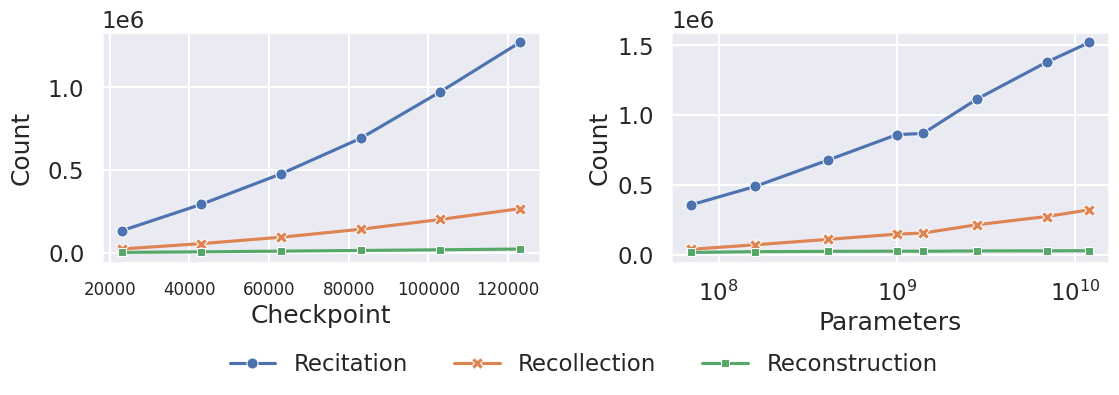

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(13, 3))

# set figure 1
# first figure is a line plot of the counts of each category for across intermediate checkpoints

sns.lineplot(ax=axes[0], data=intermediate_checkpoint_counts_frame, dashes=False, markers=True, markersize=8)

# rotate x axis labels
# axes[0].tick_params(axis='x', rotation=20)

# make x labels smaller
axes[0].tick_params(axis='x', labelsize=12)

# Add y label for Count
axes[0].set_ylabel("Count", labelpad=label_title_padding)

# add padding for labels
fig.subplots_adjust(wspace=0.2)

# # make x axis log scale
# axes[0].set_xscale("log")

# # have a common legend for both plots centered below the figure. No legend box
axes[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.3), ncol=4, frameon=False)

# set figure 2
# the second figure is a line plot of the counts of each category across parameter count

sns.lineplot(ax=axes[1], data=final_checkpoint_counts_frame, dashes=False, markers=True, markersize=8)

# make x axis log scale
axes[1].set_xscale("log")

# Set x label to "Parameters"
axes[1].set_xlabel("Parameters")

# Add y label for Count
axes[1].set_ylabel("Count")

# remove legend
axes[1].legend().remove()

# add padding for labels
fig.subplots_adjust(wspace=0.30)

fig.savefig(f"categories_across_time+scale_recitation={RECITATION_THRESHOLD}.png", bbox_inches="tight")



### Figure: Prevalence and Percents of Memories by Taxonomy Across Param Count

In [38]:
counts_frame = combined_dataframe.value_counts(["Param Count", "category"]).unstack().reindex(split_to_param_count.values())
display(counts_frame)

category,Recitation,Recollection,Reconstruction
Param Count,,,
70000000,356982,38351,16115
160000000,488998,70805,21397
410000000,677656,109520,23864
1000000000,860603,147248,25021
1400000000,868737,154990,24377
2800000000,1114324,214053,26839
6900000000,1379503,273262,27531
12000000000,5365345,1113646,111274


In [40]:
all_percents = []
for param_count in tqdm(split_to_param_count.values()):
    model_examples = combined_dataframe[combined_dataframe["Param Count"] == param_count]
    model_percents = model_examples.value_counts("category", normalize=True).to_dict()
    for category in model_percents:
        all_percents.append({
            "Model": model_examples["Model"].unique()[0],
            "Param Count": param_count,
            "category": category,
            "percent": model_percents[category],
        })

percents_frame = pd.DataFrame(all_percents).pivot(index="Model", columns="category", values="percent").reindex(split_to_param_count.keys())
display(percents_frame)

100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


category,Recitation,Recollection,Reconstruction
Model,,,
70m,0.867624,0.093210,0.039167
160m,0.841359,0.121826,0.036815
410m,0.835540,0.135036,0.029424
1b,0.833214,0.142562,0.024225
1.4b,0.828865,0.147877,0.023258
2.8b,0.822248,0.157948,0.019804
6.9b,0.820988,0.162627,0.016385
12b,0.814132,0.168983,0.016885


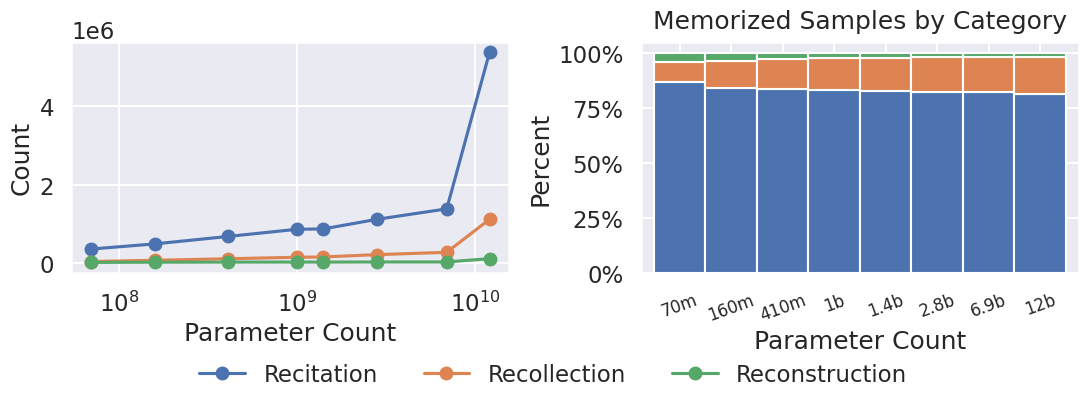

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(13, 3))

counts_frame = combined_dataframe.value_counts(["Param Count", "category"]).unstack().reindex(split_to_param_count.values())
counts_frame.plot.line(
    ax=axes[0],
    rot=0,
    ylabel="Count",
    marker="o",
)

# log x axis
axes[0].set_xscale("log")

# right plot is the each category across model size
# create a normalized bar plot stacked by category with a seperate bar for each Model
# have no space between bars
percents_frame.plot.bar(
    stacked=True,
    ax=axes[1],
    rot=0,
    width=1,
    ylabel="Percent",
)

axes[1].set_title("Memorized Samples by Category", pad=label_title_padding)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))

# rotate x axis labels
axes[1].tick_params(axis='x', rotation=20, labelsize=12)

# remove right legend
axes[1].get_legend().remove()

# add padding for labels
fig.subplots_adjust(wspace=0.30)

# have a common legend for both plots centered below the figure. No legend box
axes[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.3), ncol=4, frameon=False)

# set x label for both plots as "Parameter Count"
for ax in axes:
    ax.set_xlabel("Parameter Count")

# save figure_categories_count_pcercents.png
plt.savefig("figure_categories_count_percents.png", bbox_inches='tight')